In [2]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_plotting, utils_plotting_accelerometer, utils_accelerometer, utils_misc

from lib_accelerometer import ACCELEROMETER 
from lib_data import DATA_IO
from lib_statistics import NON_PARAMETRIC_TEST

In [3]:
PATH_CURR   = os.path.abspath(os.curdir)    # current code
PATH        = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated
SUB_LIST    = utils_misc.get_SUB_list(DATA_IO.path_data) # get the SUB id list which we have a recording of them

# 1. Load accelerometer event history of all patient
df_accelerometer_events = pd.read_csv(DATA_IO.path_events + "EVENTS_ACC.csv")

# removing irregular dyskinesia scores
df_accelerometer_events = df_accelerometer_events[(~df_accelerometer_events['dyskinesia_arm'].isnull()) & (~df_accelerometer_events['dyskinesia_total'].isnull())]
    
# removing uncontinious events due to the artifact removal 
df_accelerometer_events = df_accelerometer_events[df_accelerometer_events.duration == (df_accelerometer_events.event_finish_index-df_accelerometer_events.event_start_index)/512]

# Extract Accelerometer Recordings of Events

In [ ]:
accelerometer_events = pd.DataFrame()

for SUB in SUB_LIST: 
    
    patient_kinematics = ACCELEROMETER(PATH, SUB)
    patient_events     = df_accelerometer_events[df_accelerometer_events.patient==int(SUB)]
    patient_acc_events = patient_kinematics.extract_accelerometer_events(patient_events)

    # If the accelerometer events dictionary is empty assign the patient event dictionary to it
    if(len(accelerometer_events)==0):
        accelerometer_events = patient_acc_events

    # otherwise, merge previous patient events with current patient events 
    else:
        accelerometer_events = utils_misc.combine_dataframes(accelerometer_events, patient_acc_events)
        
accelerometer_events.to_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")

ACCELEROMETER: SUB-008
... loading started
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_right.P
... pickle loading: C:\Users\a.kaymak\Desktop\Papers\2025 Parkinson STN-DBS Dyskinesia LFP-ECG\files\data\sub-008\008_mergedData_v4.0_acc_left.P


# Plot Event Categories

In [6]:
df_accelerometer_events        = pd.read_pickle(DATA_IO.path_events + "ACCELEROMETER_RECORDINGS.pkl")
df_accelerometer_events        = df_accelerometer_events[(df_accelerometer_events.event_category=="tapping")]
df_accelerometer_events["LID"] = df_accelerometer_events['dyskinesia_total'].apply(lambda x: 'no-LID' if x == 'none' else 'LID')

## 1. Tapping Events - LID vs no-LID

### 1.1. Overal Activity

<Figure size 640x480 with 0 Axes>

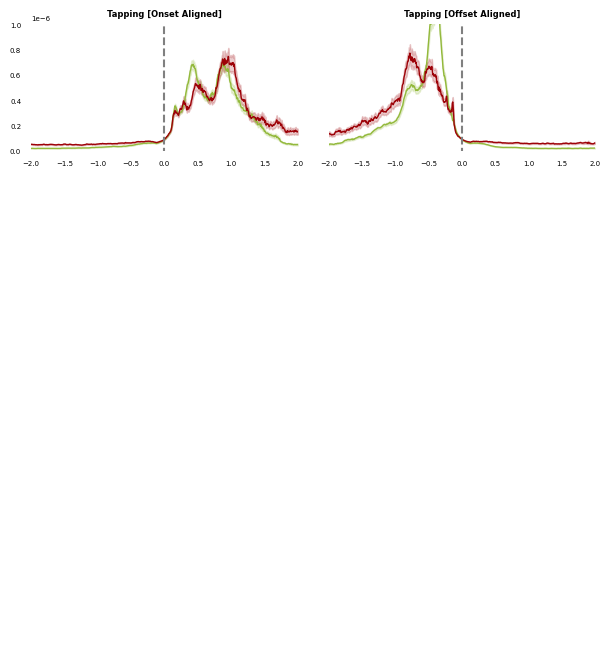

In [6]:
utils_plotting_accelerometer.plot_accelerometer_events_for_event_category(df_accelerometer_events, event_category="tapping", 
                                                                          figure_name=DATA_IO.path_figure + "accelerometer/tapping_onset_vs_offset")

### 1.2 Patient-Specific Activity

In [ ]:
for SUB in SUB_LIST:
    utils_plotting_accelerometer.plot_accelerometer_events_for_event_category(df_accelerometer_events[df_accelerometer_events.patient==int(SUB)], 
                                                                              event_category="tapping", 
                                                                              figure_name=DATA_IO.path_figure + "patient_figures/" + SUB + "/tapping_noLID_vs_LID")

<Figure size 640x480 with 0 Axes>

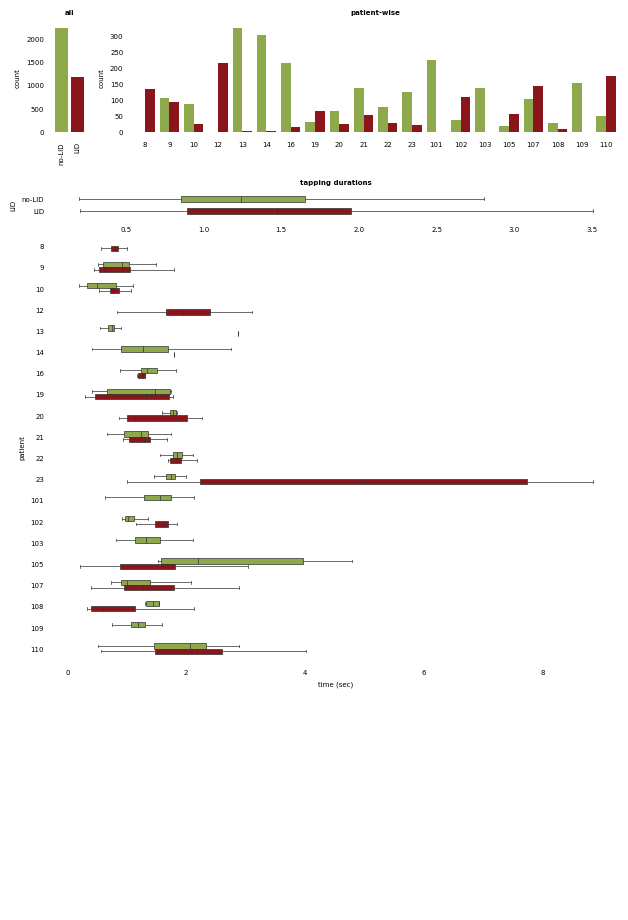

In [10]:
import utils_plotting

plt = utils_plotting.get_figure_template()
ax1 = plt.subplot2grid((75, 50), (0, 0), colspan=3, rowspan=13)
ax2 = plt.subplot2grid((75, 50), (0, 7), colspan=43, rowspan=13)
ax3 = plt.subplot2grid((75, 50), (20, 0), colspan=50, rowspan=3)
ax4 = plt.subplot2grid((75, 50), (25, 0), colspan=50, rowspan=50)

ax1 = utils_plotting.count_plot(df_accelerometer_events, feat_x="LID", hue="", axis=ax1, order=["no-LID","LID"], hue_order=["no-LID","LID"],
                                color_palette=[utils_plotting.colors["no_LID"], utils_plotting.colors["tapping"]["severe"]])

ax2 = utils_plotting.count_plot(df_accelerometer_events, feat_x="patient", hue="LID", axis=ax2, order="", hue_order=["no-LID","LID"],
                                color_palette=[utils_plotting.colors["no_LID"], utils_plotting.colors["tapping"]["severe"]])

ax3 = utils_plotting.boxplot(df_accelerometer_events, feat_x="duration", feat_y="LID", hue="", axis=ax3, orient="h", order=["no-LID","LID"], hue_order=["no-LID","LID"],
                             color_palette=[utils_plotting.colors["no_LID"], utils_plotting.colors["tapping"]["severe"]])

ax4 = utils_plotting.boxplot(df_accelerometer_events, feat_x="duration", feat_y="patient", hue="LID", axis=ax4, orient="h", order="", hue_order=["no-LID","LID"],
                             color_palette=[utils_plotting.colors["no_LID"], utils_plotting.colors["tapping"]["severe"]])

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title("all", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax2.set_title("patient-wise", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax3.set_title("tapping durations", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax4.set_xlabel("time (sec)", fontsize=utils_plotting.LABEL_SIZE)

plt.savefig(DATA_IO.path_figure + "accelerometer/tapping_kinematics_LID_vs_noLID.png", dpi=300)
plt.savefig(DATA_IO.path_figure + "accelerometer/tapping_kinematics_LID_vs_noLID.svg", dpi=300)


## 2 Tapping Events - LID Severity (Arm Strategy)

### 2.1 Overall Activity

<Figure size 640x480 with 0 Axes>

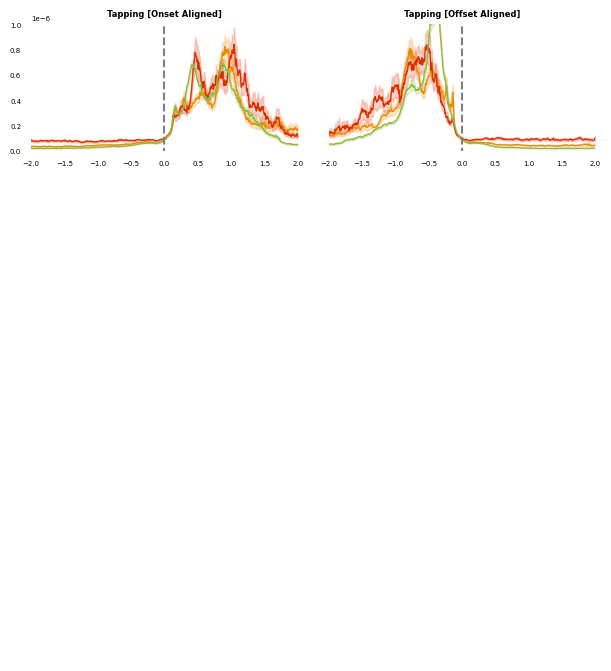

In [8]:
utils_plotting_accelerometer.plot_accelerometer_events_for_dyskinesia_severity(df_accelerometer_events, 
                                                                               event_category="tapping", dyskinesia_strategy="arm",
                                                                               figure_name=DATA_IO.path_figure + "accelerometer/tapping_dyskinesia_severity_arms")

### 2.2 Patient-Specific Activity

In [ ]:
for SUB in SUB_LIST:
    utils_plotting_accelerometer.plot_accelerometer_events_for_dyskinesia_severity(df_accelerometer_events[df_accelerometer_events.patient==int(SUB)], 
                                                                                   event_category="tapping", dyskinesia_strategy="arm",
                                                                                   figure_name=DATA_IO.path_figure + "patient_figures/" + SUB + "/tapping_LID_severity_arm")

<Figure size 640x480 with 0 Axes>

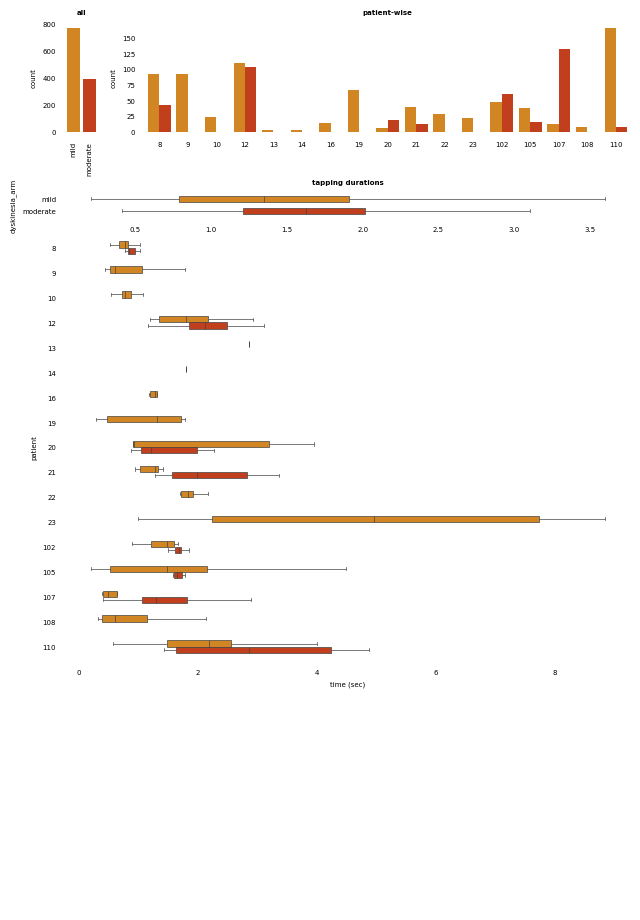

In [16]:
plt = utils_plotting.get_figure_template()
ax1 = plt.subplot2grid((75, 50), (0, 0), colspan=3, rowspan=13)
ax2 = plt.subplot2grid((75, 50), (0, 7), colspan=43, rowspan=13)
ax3 = plt.subplot2grid((75, 50), (20, 0), colspan=50, rowspan=3)
ax4 = plt.subplot2grid((75, 50), (25, 0), colspan=50, rowspan=50)

strategy = "dyskinesia_arm"

ax1 = utils_plotting.count_plot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], feat_x=strategy, hue="", axis=ax1, 
                                hue_order=["mild","moderate"], order=["mild","moderate"],
                                color_palette=[utils_plotting.colors["tapping"]["mild"],
                                               utils_plotting.colors["tapping"]["moderate"]])

ax2 = utils_plotting.count_plot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], feat_x="patient", hue=strategy, axis=ax2, 
                                hue_order=["mild","moderate"], order="",
                                color_palette=[utils_plotting.colors["tapping"]["mild"],
                                               utils_plotting.colors["tapping"]["moderate"]])

ax3 = utils_plotting.boxplot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], 
                             feat_x="duration", feat_y=strategy, hue="", axis=ax3, orient="h",
                             hue_order=["mild","moderate"], order=["mild","moderate"],
                             color_palette=[utils_plotting.colors["tapping"]["mild"],
                                            utils_plotting.colors["tapping"]["moderate"]])

ax4 = utils_plotting.boxplot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], 
                             feat_x="duration", feat_y="patient", hue=strategy, axis=ax4, orient="h",
                             hue_order=["mild","moderate"], order="",
                             color_palette=[utils_plotting.colors["tapping"]["mild"],
                                            utils_plotting.colors["tapping"]["moderate"]])

ax1.set_title("all", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set_title("patient-wise", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax3.set_title("tapping durations", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax4.set_xlabel("time (sec)", fontsize=utils_plotting.LABEL_SIZE)

plt.savefig(DATA_IO.path_figure + "accelerometer/tapping_kinematics_LID_severity_arms.png", dpi=300)
plt.savefig(DATA_IO.path_figure + "accelerometer/tapping_kinematics_LID_severity_arms.svg", dpi=300)


## 3 Tapping Events - LID Severity (Total Body Strategy)

### 3.1. Overall Activity

<Figure size 640x480 with 0 Axes>

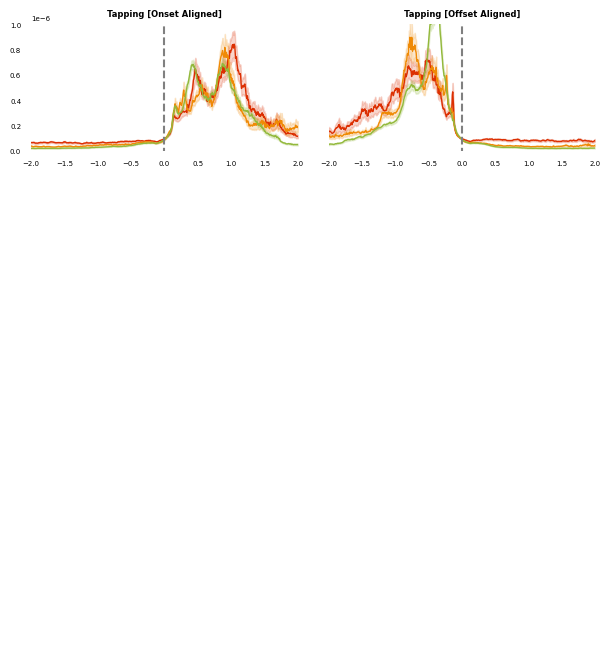

In [20]:
utils_plotting_accelerometer.plot_accelerometer_events_for_dyskinesia_severity(df_accelerometer_events, 
                                                                               event_category="tapping", dyskinesia_strategy="total",
                                                                               figure_name=DATA_IO.path_figure + "accelerometer/tapping_dyskinesia_severity_total")

### 3.2. Patient-Specific Activity

In [ ]:
for SUB in SUB_LIST:
    utils_plotting_accelerometer.plot_accelerometer_events_for_dyskinesia_severity(df_accelerometer_events[(df_accelerometer_events.patient==int(SUB))], 
                                                                                   event_category="tapping", dyskinesia_strategy="total",
                                                                                   figure_name=DATA_IO.path_figure + "patient_figures/" + SUB + "/tapping_LID_severity_total")

<Figure size 640x480 with 0 Axes>

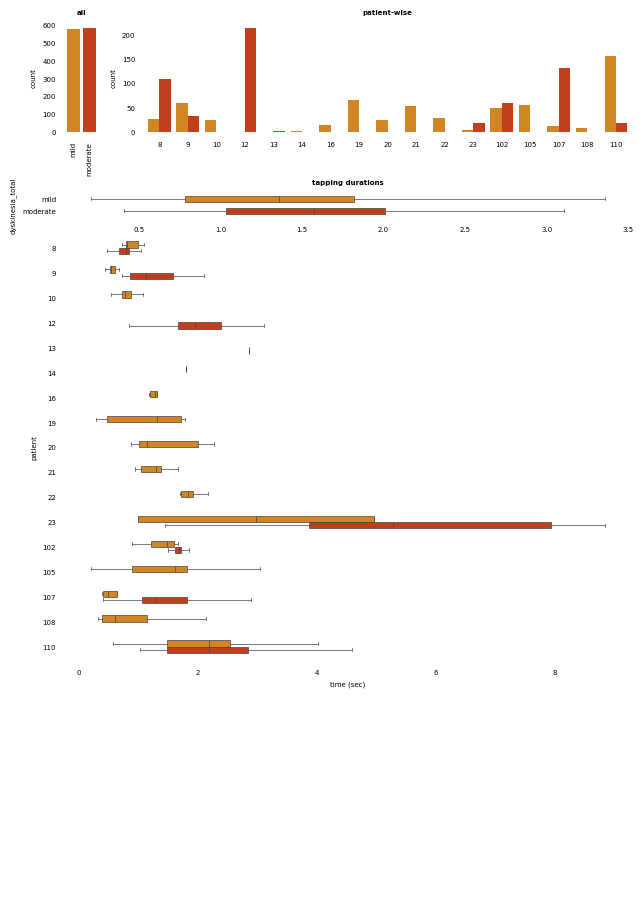

In [26]:
plt = utils_plotting.get_figure_template()
ax1 = plt.subplot2grid((75, 50), (0, 0), colspan=3, rowspan=13)
ax2 = plt.subplot2grid((75, 50), (0, 7), colspan=43, rowspan=13)
ax3 = plt.subplot2grid((75, 50), (20, 0), colspan=50, rowspan=3)
ax4 = plt.subplot2grid((75, 50), (25, 0), colspan=50, rowspan=50)

strategy = "dyskinesia_total"

ax1 = utils_plotting.count_plot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], feat_x=strategy, hue="", axis=ax1, 
                                hue_order=["mild","moderate"], order=["mild","moderate"],
                                color_palette=[utils_plotting.colors["tapping"]["mild"],
                                               utils_plotting.colors["tapping"]["moderate"]])

ax2 = utils_plotting.count_plot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], feat_x="patient", hue=strategy, axis=ax2, 
                                hue_order=["mild","moderate"], order="",
                                color_palette=[utils_plotting.colors["tapping"]["mild"],
                                               utils_plotting.colors["tapping"]["moderate"]])

ax3 = utils_plotting.boxplot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], 
                             feat_x="duration", feat_y=strategy, hue="", axis=ax3, orient="h",
                             hue_order=["mild","moderate"], order=["mild","moderate"],
                             color_palette=[utils_plotting.colors["tapping"]["mild"],
                                            utils_plotting.colors["tapping"]["moderate"]])

ax4 = utils_plotting.boxplot(df_accelerometer_events[df_accelerometer_events[strategy]!="none"], 
                             feat_x="duration", feat_y="patient", hue=strategy, axis=ax4, orient="h",
                             hue_order=["mild","moderate"], order="",
                             color_palette=[utils_plotting.colors["tapping"]["mild"],
                                            utils_plotting.colors["tapping"]["moderate"]])

ax1.set_title("all", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set_title("patient-wise", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax3.set_title("tapping durations", fontsize=utils_plotting.LABEL_SIZE, weight="bold")
ax4.set_xlabel("time (sec)", fontsize=utils_plotting.LABEL_SIZE)

plt.savefig(DATA_IO.path_figure + "accelerometer/tapping_kinematics_LID_severity_total_body.png", dpi=300)
plt.savefig(DATA_IO.path_figure + "accelerometer/tapping_kinematics_LID_severity_total_body.svg", dpi=300)
